In [42]:
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import pearsonr
import itertools
np.warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler

In [43]:
df = pd.read_csv('ISLR/data/Smarket.csv',index_col=0, parse_dates=True)

In [44]:
r, c = df.shape
print(c)
for a, b in enumerate(df, 1):
    list = "".join('{}. \'{}\''.format(a, b))
    print (list, end=" ")

9
1. 'Year' 2. 'Lag1' 3. 'Lag2' 4. 'Lag3' 5. 'Lag4' 6. 'Lag5' 7. 'Volume' 8. 'Today' 9. 'Direction' 

In [14]:
df.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


In [15]:
print(df['Direction'].value_counts())

Up      648
Down    602
Name: Direction, dtype: int64


In [16]:
len(df.index)

1250

In [17]:
df

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1246,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1247,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1248,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1249,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [18]:
df[['Lag1', 'Year', 'Volume', 'Lag2', 'Lag5', 'Lag4', 'Lag3', 'Today']].corr().round(3)

,Lag1,Year,Volume,Lag2,Lag5,Lag4,Lag3,Today
Lag1,1.000,0.030,0.041,-0.026,-0.006,-0.003,-0.011,-0.026
Year,0.030,1.000,0.539,0.031,0.030,0.036,0.033,0.030
Volume,0.041,0.539,1.000,-0.043,-0.022,-0.048,-0.042,0.015
Lag2,-0.026,0.031,-0.043,1.000,-0.004,-0.011,-0.026,-0.010
Lag5,-0.006,0.030,-0.022,-0.004,1.000,-0.027,-0.019,-0.035
Lag4,-0.003,0.036,-0.048,-0.011,-0.027,1.000,-0.024,-0.007
Lag3,-0.011,0.033,-0.042,-0.026,-0.019,-0.024,1.000,-0.002
Today,-0.026,0.030,0.015,-0.010,-0.035,-0.007,-0.002,1.000


In [19]:
def calc_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcol = pd.DataFrame(columns=df.columns)
    pval = dfcol.transpose().join(dfcol, how='outer')
    for r in df.columns:
        for c in df.columns:
            pval[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pval

calc_pvalues(df[['Lag1', 'Year', 'Volume', 'Lag2', 'Lag5', 'Lag4', 'Lag3', 'Today']])

,Lag1,Year,Volume,Lag2,Lag5,Lag4,Lag3,Today
Lag1,0,0.2941,0.1483,0.353,0.8411,0.916,0.7028,0.3555
Year,0.2941,0,0,0.2797,0.2926,0.2073,0.2409,0.2877
Volume,0.1483,0,0,0.1253,0.437,0.0871,0.1394,0.6063
Lag2,0.353,0.2797,0.1253,0,0.9,0.7015,0.3603,0.7173
Lag5,0.8411,0.2926,0.437,0.9,0,0.3387,0.5065,0.2181
Lag4,0.916,0.2073,0.0871,0.7015,0.3387,0,0.3955,0.8075
Lag3,0.7028,0.2409,0.1394,0.3603,0.5065,0.3955,0,0.9311
Today,0.3555,0.2877,0.6063,0.7173,0.2181,0.8075,0.9311,0


In [20]:
corr = df[['Lag1', 'Year', 'Volume', 'Lag2', 'Lag5', 'Lag4', 'Lag3', 'Today']].corr().round(2)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Lag1,Year,Volume,Lag2,Lag5,Lag4,Lag3,Today
Lag1,1.00,0.03,0.04,-0.03,-0.01,-0.00,-0.01,-0.03
Year,0.03,1.00,0.54,0.03,0.03,0.04,0.03,0.03
Volume,0.04,0.54,1.00,-0.04,-0.02,-0.05,-0.04,0.01
Lag2,-0.03,0.03,-0.04,1.00,-0.00,-0.01,-0.03,-0.01
Lag5,-0.01,0.03,-0.02,-0.00,1.00,-0.03,-0.02,-0.03
Lag4,-0.00,0.04,-0.05,-0.01,-0.03,1.00,-0.02,-0.01
Lag3,-0.01,0.03,-0.04,-0.03,-0.02,-0.02,1.00,-0.00
Today,-0.03,0.03,0.01,-0.01,-0.03,-0.01,-0.00,1.00


<h1>Interpretation</h1>
<h2>Correlation \$r and \$p and heatmap</h2>

The first table prints the correlation coefficients. The coefficient is calculated as a strong possible correlation (close to number 1) and strong negative correlation (close to number - 1). Positive correlation means that as one of the numbers increases, the second number will increase as well. Negative correlation means that as one number increases, the other will decrease.  

Only features Volume with Year are strongly correlated and as if one of the numbers goes up the other goes up as well (as they are closer to 1). The opposite, there seems to be only little correlation between today's returns and previous days returns.  

The second table prints the table of p - values corresponding to the significance levels of the correlations. In general the p - value evaluates how well the data rejects the null hypothesis, which shows whether a predictor is statistically significant. The cutoff for specifying the significance is known as the alpha value, which is most commonly set to 0.05. Thus, if the p - value is less than the 0.05 then the null hypothesis is rejected. As can be see from the results above the p-value of only Year and Volume is 0, which is less than the significance level 0.05. The conclusion is that Year and Volume are significantly correlated with a correlation coefficient of 0.54 and p-value of 0.    

Lastly the table is printed in colors as a heatmap. In the generated colored heatmap, negative correlations are in blue and positive ones in red color. If there is no correlation between two variables, meaning when the correlation is close to 0, then the color is grey. Thus with the heatmap, we can see again that Year and Volume are correlated. The heatmap visualization helps to identify the correlations faster, however the explanation for the numbers is the same as the explanation for the correlation coefficient table above.

[Text(0, 0.5, 'Volume, the number of shares traded on the previous day, in billions'),
 Text(0.5, 0, 'Year')]

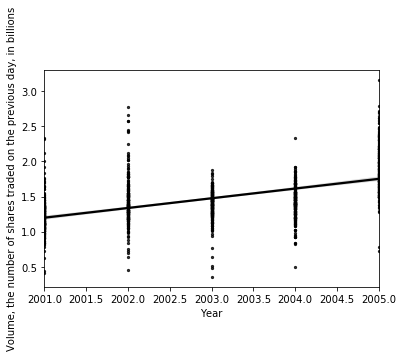

In [26]:
ax = sns.regplot(x = "Year", y = "Volume", 
            data=df, 
            marker='o', 
            color='black', 
            scatter_kws={'s':5})
ax.set(xlabel='Year', ylabel='Volume, the number of shares traded on the previous day, in billions')

<h1>Interpretation</h1>
  
By plotting Year with Volume it is visible that Volume is increasing over time. More specifically, starting from 2001 the average number of shares traded daily increases until 2005.

In [27]:
model = sm.formula.glm('Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume ',
                       family=sm.families.Binomial(), data=df)
result = model.fit()
print(result.summary())

                          Generalized Linear Model Regression Results                           
Dep. Variable:     ['Direction[Down]', 'Direction[Up]']   No. Observations:                 1250
Model:                                              GLM   Df Residuals:                     1243
Model Family:                                  Binomial   Df Model:                            6
Link Function:                                    logit   Scale:                          1.0000
Method:                                            IRLS   Log-Likelihood:                -863.79
Date:                                  Wed, 04 Mar 2020   Deviance:                       1727.6
Time:                                          18:11:20   Pearson chi2:                 1.25e+03
No. Iterations:                                       4                                         
Covariance Type:                              nonrobust                                         
                 coef    std e

<h1>Interpretation</h1>

The smallest p-value associated with Lag1, and the **positive** coefficient means that if hte market had a positive return the previous day, it is likely to go up today again. But since the p-value of 0.145 is still > 0.05 we can not reject the null hypothesis and can conclude that there is no clear relation between Lag1 and Direction. For all other p-values it is similar since all of them are > 0.05.

In [28]:
predictions = result.predict()
print(predictions[0:10]) #1:10

[0.49291587 0.51853212 0.51886117 0.48477764 0.48921884 0.49304354
 0.50734913 0.49077084 0.48238647 0.51116222]


In [29]:
print("Dependent variables:")
print(result.model.endog_names)
print("\n Assigned dummy variables:")
print(np.column_stack((df[["Direction"]], 
                       result.model.endog)))

Dependent variables:
['Direction[Down]', 'Direction[Up]']

 Assigned dummy variables:
[['Up' 0.0]
 ['Up' 0.0]
 ['Down' 1.0]
 ...
 ['Up' 0.0]
 ['Down' 1.0]
 ['Down' 1.0]]


In [30]:
predictions_nominal = [ "Up" if x < 0.5 else "Down" for x in predictions]
print(confusion_matrix(df["Direction"], 
                       predictions_nominal))
print('Accuracy Score:',accuracy_score(df["Direction"], predictions_nominal))

[[145 457]
 [141 507]]
Accuracy Score: 0.5216


<h1>Interpretation</h1>


Up (0.0) and Down (1.0) have assigned dummy variables to them, as can be seen in the matrix above. The off - diagonal elements present the incorrect predictions (457 and 141). The confusion matrix presents also diagonal elements, which indicate the correct predictions (145 + 507 = 652 / 1250 = 0.5216)  So, from this calculation we get the mean or accuracy score to compute the fraction of days for which the prediction was correct. In this example the prediction was accurate or correct for predicting the movement of the market 52.2\% of the time. With this value we also get the training error rate, which is in this case 100 - 52.2 = 47.8\%. However, the training error rate tends to underestimate the test error rate (as stated in the course literature book). Thus, further steps will be taken in the following parts to assess the accuracy of the logistic regression model.

In [31]:
model = sm.formula.glm('Direction ~ Lag1 + Lag2',
                       family=sm.families.Binomial(), data=df)
result = model.fit()
predictions = result.predict()
predictions_nominal = [ "Up" if x < 0.5 else "Down" for x in predictions]
print(confusion_matrix(df["Direction"], 
                       predictions_nominal))
print('Accuracy Score:',accuracy_score(df["Direction"], predictions_nominal))

[[114 488]
 [102 546]]
Accuracy Score: 0.528


<h1>Interpretation</h1>

This diagonals and off - diagonals present again the correct and incorrect predictions. So, in this example where the subset of Lag1 + Lag2 predictors were only shown, the correct predictions are 114 + 546 = 660 / 1250 = 0.528 . Thus, compared to the previous example, where now only Lag1 + Lag2 are choosen as predictors, the prediction was accurate / correct for predicting the movement of the market 52.8\% of the time. This is slightly better than when all predictors were choosen in the previous example. 

<h1>Performing an LDA</h1> 

In [32]:
X_train = df[['Lag1','Lag2']]
y_train = df['Direction']

X_test = df[['Lag1','Lag2']]
y_test = df['Direction']

lda = LinearDiscriminantAnalysis()
model = lda.fit(X_train, y_train)

print('Prior probabilities of groups: ')
print(model.priors_)
print('\n Group means: ')
print(model.means_)
print('\n Coefficients of linear discriminants: ')

def pretty_scalings(lda, X, out=False):
    ret = pd.DataFrame(lda.scalings_, index=X.columns, columns=["LD"+str(i+1) for i in range(lda.scalings_.shape[1])])
    if out:
     #  print("Coefficients of linear discriminants:")
        display(ret)
    return ret

pretty_scalings_ = pretty_scalings(model, X_train, out=True)

Prior probabilities of groups: 
[0.4816 0.5184]

 Group means: 
[[ 0.05068605  0.03229734]
 [-0.03969136 -0.02244444]]

 Coefficients of linear discriminants: 


,LD1
Lag1,-0.756761
Lag2,-0.470787


(array([  3.,   5.,  12.,  20.,  72., 182., 375., 350., 158.,  40.,  19.,
         10.,   2.,   2.]),
 array([-7.126     , -6.08821429, -5.05042857, -4.01264286, -2.97485714,
        -1.93707143, -0.89928571,  0.1385    ,  1.17628571,  2.21407143,
         3.25185714,  4.28964286,  5.32742857,  6.36521429,  7.403     ]),
 <a list of 14 Patch objects>)

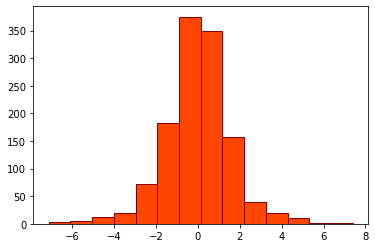

In [33]:
# create new column and use that for histogram, to have even an overlapping histogram
df["lag1_lag2"] = df['Lag1']+df['Lag2'] 
dir_up = df[df['Direction']=="Up"]
dir_down = df[df['Direction']=="Down"]

plt.hist(df["lag1_lag2"],
        facecolor='orangered',
        edgecolor='maroon',
        bins=14)

# *****Another failed attempt*******
# import matplotlib.pyplot as plt
# y = df["lag1_lag2"]
# x = df['Direction']
# plt.bar(x,y) # A bar chart
# plt.show()

<h1>Interpretation</h1>

Prior probabilities of groups shows that 48.2\% of the trained observations correspond to the days when the market went down and 51.8\% to those when the market went up.  
The group means are the average of each predictor within each class. The results here indicate that the returns for the previous two days tend to be positive when the market declines and negative when the market increases.  
Coefficients of linear discriminants gives in this example the linear combination of Lag1 and Lag2 that are used to form the LDA decision rule. Thus, if - 0.757 x Lag1 - 0.471 x Lag2 is large, the the prediction from LDA would be that the market would increase, and on the other hand if it is small, then the LDA prediction would say a market decline.  
The failed attempt at the histogram:  What it should really print is actually the trained model of x = Lag1 + Lag2 and y - Direction (thus Direction is either Up or Down)

<h1> Using the LDA model </h1>

In [34]:
pred = model.predict(X_test)
#print(np.unique(pred, return_counts = True))
print(confusion_matrix(pred, y_test))
print('\n Accuracy Score:',accuracy_score(df["Direction"], pred))

[[114 102]
 [488 546]]

 Accuracy Score: 0.528


<h1>Interpretation</h1>


This diagonals and off - diagonals present again the correct and incorrect predictions. So, in this example where the subset of Lag1 + Lag2 predictors were only shown, the correct predictions are 114 + 546 = 660 / 1250 = 0.528 . Thus, compared to the logistic regression, where the predictors were the same, it is visible that the confusion matrix and accuracy score are the same too.

<h1>Performing an QDA</h1> 

In [35]:
X_train = df[['Lag1','Lag2']]
y_train = df['Direction']

X_test = df[['Lag1','Lag2']]
y_test = df['Direction']

qda = QuadraticDiscriminantAnalysis()
model = qda.fit(X_train, y_train)

print('Prior probabilities of groups: ')
print(model.priors_)
print('\n Group means: ')
print(model.means_)

Prior probabilities of groups: 
[0.4816 0.5184]

 Group means: 
[[ 0.05068605  0.03229734]
 [-0.03969136 -0.02244444]]


<h1>Interpretation</h1>

The results for prior probabilities of groups and for group means are the same as when performed with LDA, since the groupps are the same (thus, same interpretation applies). However, this time, there are no linear discrimintants. That is simply because QDA performs quadratic function of the predictors and not linear.

In [36]:
pred = model.predict(X_test)
print(confusion_matrix(pred, y_test))
print('\n Accuracy Score:',accuracy_score(df["Direction"], pred))

[[109  94]
 [493 554]]

 Accuracy Score: 0.5304


<h1>Interpretation</h1>

This diagonals and off - diagonals present again the correct and incorrect predictions. So, the correct predictions are 109 + 554 = 663 / 1250 = 0.530 . Thus, compared to the logistic regression, and LDA, where all models had same predictors, it is visible that the confusion matrix and accuracy score have best results when performing QDA. The accuracy score is now 53.0\%  

<h1>Using K-Nearest Neighbors Clustering</h1> 

In [45]:
# objects before 2005 set to true
train = df[df['Year']<2005]
train.shape #998 

# set to !train, thus to false
not_train = df[df['Year']==2005]
not_train.shape

(252, 9)

In [38]:
X_train = df[df['Year']<2005][['Lag1','Lag2']]
y_train = df[df['Year']<2005]['Direction']

X_test = df[df['Year']==2005][['Lag1','Lag2']]
y_test = df[df['Year']==2005]['Direction']

In [39]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 1)
pred = knn.fit(X_train, y_train).predict(X_test)

In [40]:
print(confusion_matrix(y_test, pred).T)
#print(classification_report(y_test, pred, digits=3))
print('\n Accuracy Score:',accuracy_score(y_test, pred))

[[43 58]
 [68 83]]

 Accuracy Score: 0.5


In [41]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
model = knn.fit(X_train, y_train)

pred = model.predict(X_test)
print(confusion_matrix(y_test, pred).T)
#print(classification_report(y_test, pred, digits=3))
print('\n Accuracy Score:',accuracy_score(y_test, pred))

[[48 55]
 [63 86]]

 Accuracy Score: 0.5317460317460317


<h1>Interpretation</h1>

Again the aim was to predict Direction using percentage returns from Lag1 and Lag2 (the previous two days). To train the model, only the observations from years 2001 until 2004 were chosen. The year 2005 is used to perform the testing on. The confusion matrix and an accuracy score are computed for both, when K = 1 and when K = 3. K is the number of nearest neighbors used by the classifier.  
**K = 1** This diagonals and off - diagonals present again the correct and incorrect predictions. So, the correct predictions are 43 + 83 = 126 / 252 = 0.5 . The accuracy score is now 50.0\%  
**K = 3** This diagonals and off - diagonals present again the correct and incorrect predictions. So, the correct predictions are 48 + 86 = 134 / 252 = 0.532 . The accuracy score is now 53.2\%.  
Thus, when taking 3 nearest neighbors, the accuracy score improves slightly.  

Overall, it seems that KNN (3 nearest neighbors) with an accuracy score of 53.2\% followed by QDA with 53.04\% seem to provide best accuracy scores for this data.